<a href="https://www.kaggle.com/code/maziprimareza/fraud-detection?scriptVersionId=147539697" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-payment-fraud-detection/onlinefraud.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
onlinefraud = pd.read_csv('/kaggle/input/online-payment-fraud-detection/onlinefraud.csv')
data_false_sample = onlinefraud[onlinefraud.isFraud==0].sample(frac=0.05, random_state=101)
data_true = onlinefraud[onlinefraud.isFraud==1]
onlinefraud = pd.concat([data_true, data_false_sample]).sort_index()

In [4]:
onlinefraud.describe().astype('int')

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,325933,325933,325933,325933,325933,325933,325933,325933
mean,246,212298,864227,850231,1096629,1236803,0,0
std,145,755637,2940108,2938890,3394273,3700000,0,0
min,1,0,0,0,0,0,0,0
25%,156,13838,0,0,0,0,0,0
50%,249,79560,15914,0,123616,212834,0,0
75%,346,216526,123440,136190,928183,1114340,0,0
max,743,63294839,59585040,49585040,275405172,275277028,1,1


# Exploratory Data Analysis

In this EDA I sample 5% non fraud transaction because of Kaggle memory capacity. 6 Mio rows are too large for EDA and modeling in Kaggle Notebook.

Fraud transaction happened on 0.12% total transaction, after sampling 2.5% of total transactions. Due to sampling, I don't need to handle imbalance dataset. From EDA, I found that fraud transaction only happened in Cash Out and Transfer, I decided to remove other types of transaction from prediction and assume no fraud happened to other types transaction in the future. The amound of loss due to this fraud transaction is around 12B.

Fraud also happened in Cash Out and Transfer only, so the other types are ignored.

There are a different distribution between each independent variables with the target variables. The model might perform good because of this.

In [5]:
print("The amount of loss due to fraud transaction:")
onlinefraud[onlinefraud.isFraud==1]['amount'].sum()

The amount of loss due to fraud transaction:


12056415427.839998

In [6]:
onlinefraud.isFraud.value_counts(True)

isFraud
0    0.974802
1    0.025198
Name: proportion, dtype: float64

In [7]:
onlinefraud[['type', 'isFraud']].value_counts()

type      isFraud
CASH_OUT  0          111545
PAYMENT   0          107197
CASH_IN   0           70218
TRANSFER  0           26688
CASH_OUT  1            4116
TRANSFER  1            4097
DEBIT     0            2072
Name: count, dtype: int64

In [8]:
categorical = ['type']
numerical_with_fe = ['amount', 'pctOrg', 'pctDest', 'transRatioDest', 'transRatioOrg']
numerical = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
target = 'isFraud'

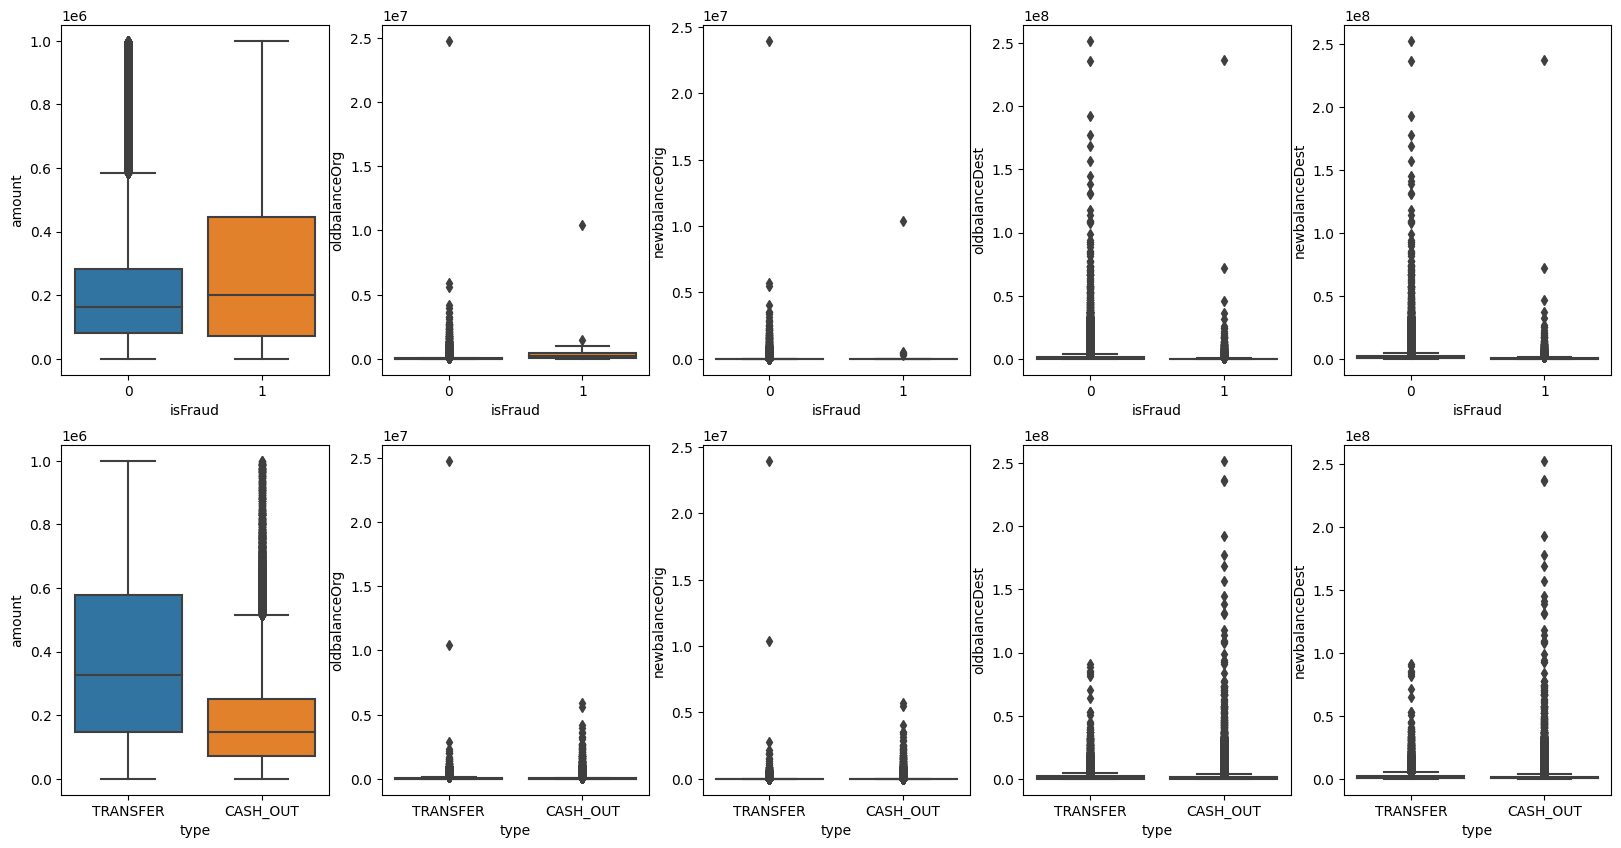

In [9]:
onlinefraud_filter = onlinefraud[(onlinefraud['type'].isin(['CASH_OUT', 'TRANSFER'])) & (onlinefraud['amount']<=1000000)]

fig, ax = plt.subplots(2,5, figsize=(20,10))

for i, col in enumerate(numerical):
    sns.boxplot(data = onlinefraud_filter , x= target, y=col, ax=ax[0, i])
    
for i, col in enumerate(numerical):
    sns.boxplot(data = onlinefraud_filter , x=categorical[0], y=col, ax=ax[1, i])

# Modeling

In [10]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

In [11]:
X = onlinefraud[numerical + categorical]
y = onlinefraud[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=28, shuffle=True)

In [12]:
params = {'learning_rate': 0.1,'iterations': 50, 'depth': 16, 'l2_leaf_reg':0.1} 
cat_features = list(X_train.select_dtypes('O').columns)
# Initialize the CatBoostClassifier object  
# with the defined hyperparameters and fit it on the training set 
model = CatBoostClassifier(**params) 
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val))

0:	learn: 0.6014007	test: 0.6012802	best: 0.6012802 (0)	total: 2.05s	remaining: 1m 40s
1:	learn: 0.5259726	test: 0.5258062	best: 0.5258062 (1)	total: 3.85s	remaining: 1m 32s
2:	learn: 0.4630613	test: 0.4628583	best: 0.4628583 (2)	total: 5.63s	remaining: 1m 28s
3:	learn: 0.4100704	test: 0.4098331	best: 0.4098331 (3)	total: 7.39s	remaining: 1m 24s
4:	learn: 0.3646095	test: 0.3643516	best: 0.3643516 (4)	total: 7.78s	remaining: 1m 10s
5:	learn: 0.3256839	test: 0.3254223	best: 0.3254223 (5)	total: 9.55s	remaining: 1m 10s
6:	learn: 0.2916672	test: 0.2913861	best: 0.2913861 (6)	total: 11.3s	remaining: 1m 9s
7:	learn: 0.2618555	test: 0.2616202	best: 0.2616202 (7)	total: 13s	remaining: 1m 8s
8:	learn: 0.2359217	test: 0.2357219	best: 0.2357219 (8)	total: 14.8s	remaining: 1m 7s
9:	learn: 0.2130428	test: 0.2128680	best: 0.2128680 (9)	total: 16.5s	remaining: 1m 5s
10:	learn: 0.1926009	test: 0.1924361	best: 0.1924361 (10)	total: 18.2s	remaining: 1m 4s
11:	learn: 0.1747517	test: 0.1745791	best: 0.174

# Prediction

The model got 0.92 F1 score, which is so good. From the precision and recall curve we could change the threshold to 0.36 and got 94% both in recall and precision.
From the model as well we could save 2.8B from fraud transaction.

In [13]:
yhat = model.predict(X_val)
yhat_proba = model.predict_proba(X_val)

In [14]:
X_val['yhat'] = pd.Series(yhat, name="yhat", index=y_val.index)
X_val['yhat_proba'] = pd.Series(yhat_proba[:,1], name="yhat", index=y_val.index)
X_val['y'] = y_val

In [15]:
confusion_matrix(y_val, yhat)

array([[79410,    50],
       [  260,  1764]])

In [16]:
print(classification_report(y_val, yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79460
           1       0.97      0.87      0.92      2024

    accuracy                           1.00     81484
   macro avg       0.98      0.94      0.96     81484
weighted avg       1.00      1.00      1.00     81484



In [17]:
precision, recall, thresholds = precision_recall_curve(y_val, yhat_proba[:,1])
precision_recall_curve = pd.DataFrame({'thresholds':thresholds,'precision': precision[:-1], 'recall':recall[:-1]})

Text(0.5, 1.0, 'Precision Recall Curve')

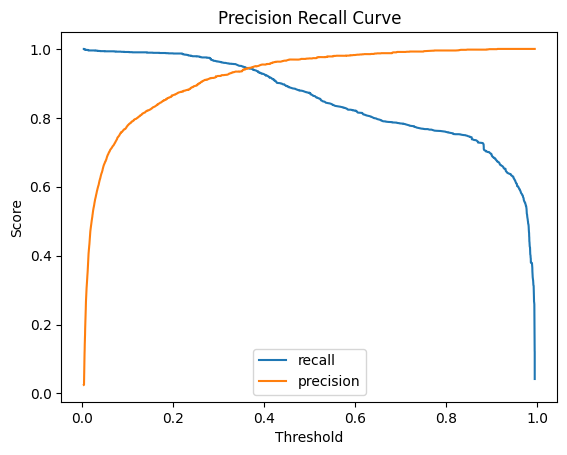

In [18]:
plt.plot(thresholds, recall[:-1], label='recall')
plt.plot(thresholds, precision[:-1], label = 'precision')
plt.legend()
plt.ylabel("Score")
plt.xlabel("Threshold")
plt.title("Precision Recall Curve")

In [19]:
precision_recall_curve[precision_recall_curve['precision']<=precision_recall_curve['recall']]

,thresholds,precision,recall
0,0.003106,0.024839,1.000000
1,0.003135,0.024840,1.000000
2,0.003138,0.024840,1.000000
3,0.003140,0.024840,1.000000
4,0.003161,0.024840,1.000000
...,...,...,...
44298,0.362740,0.942801,0.944664
44299,0.362798,0.943266,0.944664
44300,0.362908,0.943731,0.944664
44301,0.363258,0.943704,0.944170


Text(0.5, 0.98, 'Distribution of Probability Score')

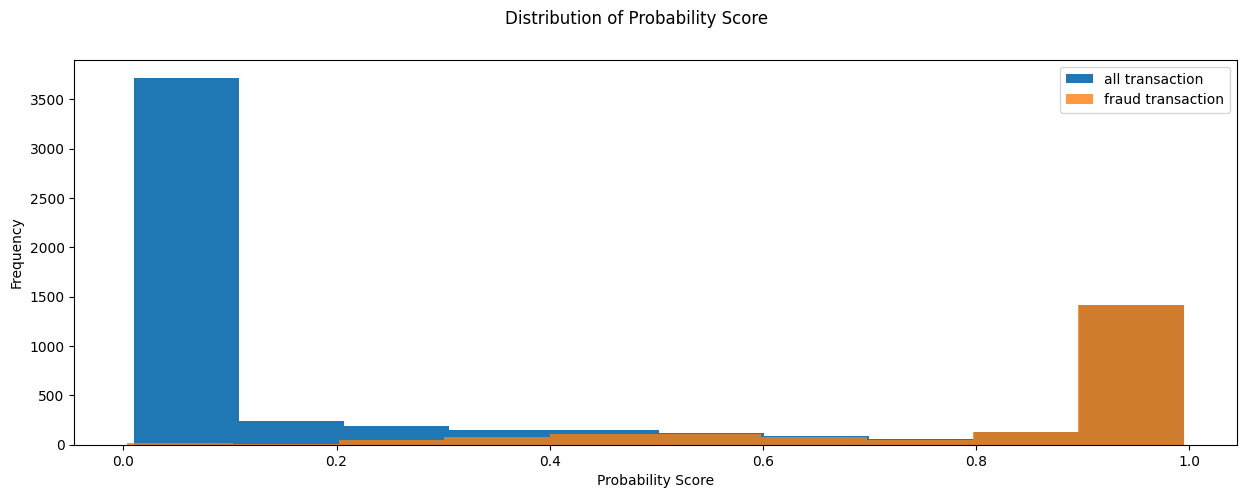

In [20]:
plt.figure(figsize=(15,5))
X_val[X_val['yhat_proba']>0.01]['yhat_proba'].plot(kind='hist', label='all transaction')
X_val[X_val['y']==1]['yhat_proba'].plot(kind='hist', alpha=0.8, label='fraud transaction')
plt.xlabel("Probability Score")
plt.legend()
plt.suptitle("Distribution of Probability Score")

In [21]:
X_val['yhat'].value_counts()

yhat
0    79670
1     1814
Name: count, dtype: int64

In [22]:
X_val[(X_val['yhat']==1) & (X_val['y']==1)]['amount'].sum()

2802769931.71

In [23]:
2826112290.2 - 2817104132.2 

9008158.0

Since fraud detection is important and I assume we don't want to detect Fraud as Non Fraud, then we can focus on Recall. From the precision recall curve above, the balance score happened when threshold is set to 0.234 with 0.88 Recall score which is so good.

In [24]:
X_val['yhat'] = 0
X_val.loc[X_val['yhat_proba']>=0.364437, 'yhat']=1

# Gain Curve
From the gain curve, we know that we can reach out to only 10% of the cases and we already cover 99.7% of total fraud transaction.

In [25]:
X_val['decile'] = pd.qcut(X_val['yhat_proba'], 10, labels=[i for i in range (10, 0, -1)])

In [26]:
gain_table = X_val.groupby('decile').agg(num_cases=('type', 'count'), num_of_resp=('y', 'sum')).reset_index().sort_values('decile', ascending=False).reset_index(drop=True)
gain_table['cumsum_resp'] = gain_table['num_of_resp'].cumsum()
gain_table['perc_of_events'] = round(gain_table['num_of_resp']/gain_table['num_of_resp'].sum() * 100, 2)
gain_table['gain'] = gain_table['perc_of_events'].cumsum()
gain_table['num_cases_cumsum'] = gain_table['num_cases'].cumsum()
gain_table = pd.concat([pd.DataFrame({'decile':0, 'num_cases':0, 'num_of_resp':0, 'cumsum_resp':0, 'perc_of_events':0,
       'gain':0, 'num_cases_cumsum':0}, index=[0]), gain_table])
gain_table['cases_pct'] = gain_table['num_cases'].cumsum()/gain_table['num_cases'].sum() * 100

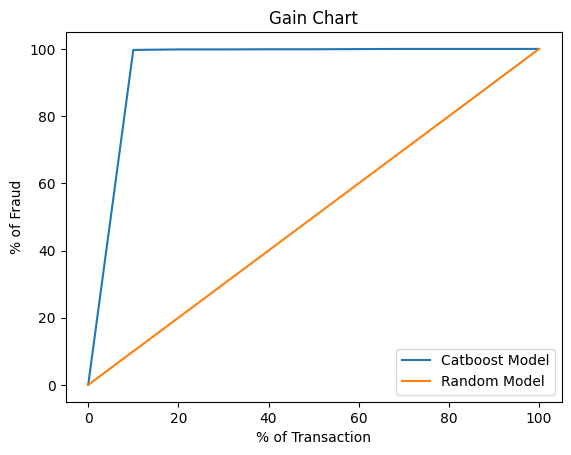

In [27]:
plt.plot(gain_table['cases_pct'], gain_table['gain'], label='Catboost Model')
plt.plot(range(0, 101, 10), range(0, 101, 10), label='Random Model')
plt.legend()
plt.xlabel("% of Transaction")
plt.ylabel("% of Fraud")
plt.title("Gain Chart")
plt.show()

In [28]:
gain_table

,decile,num_cases,num_of_resp,cumsum_resp,perc_of_events,gain,num_cases_cumsum,cases_pct
0,0,0,0,0,0.00,0.00,0,0.000000
0,1,8149,2018,2018,99.70,99.70,8149,10.000736
1,2,8148,3,2021,0.15,99.85,16297,20.000245
2,3,8096,0,2021,0.00,99.85,24393,29.935938
3,4,8201,1,2022,0.05,99.90,32594,40.000491
4,5,8148,0,2022,0.00,99.90,40742,50.000000
5,6,8148,1,2023,0.05,99.95,48890,59.999509
6,7,8149,1,2024,0.05,100.00,57039,70.000245
7,8,8148,0,2024,0.00,100.00,65187,79.999755
8,9,8148,0,2024,0.00,100.00,73335,89.999264
